In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import sampler
import torchvision.models as models


Load and process CIFAR 10 data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

Files already downloaded and verified
Files already downloaded and verified


Look at example CIFAR images

<IPython.core.display.Javascript object>


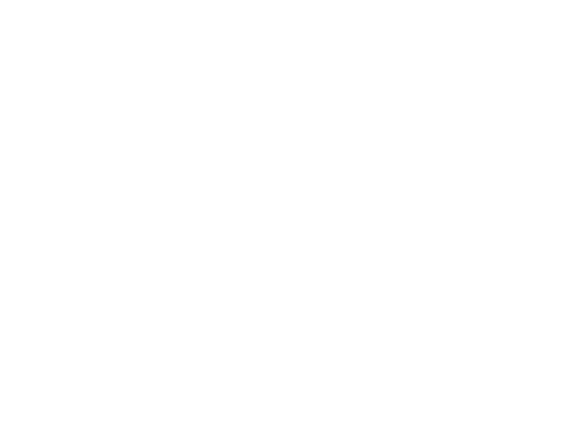

  car  ship   car  frog


Process Process-2:
    self._target(*self._args, **self._kwargs)
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    self._target(*self._args, **self._kwargs)
    r = index_queue.get()
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    r = index_queue.get()
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
KeyboardInterrupt
    return recv()
  File 

In [3]:
%matplotlib nbagg
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [273]:
import torch.utils.model_zoo as model_zoo
vgg_model = vgg_lite()
#sd = torch.load('/home/drc/Downloads/model_best.pth.tar')
#vgg_model.load_state_dict(vgg16.state_dict())
vgg_model = vgg_model.cuda()
import copy
model = copy.deepcopy(vgg_model)

In [274]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [275]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for t, (x, y) in enumerate(trainloader):
        inputs, labels = to_var(x), to_var(y.long())
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if t % 1000 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, t + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.001
[1,  1001] loss: 1.155
[1,  2001] loss: 1.152
[1,  3001] loss: 1.152
[1,  4001] loss: 1.151
[1,  5001] loss: 1.150
[1,  6001] loss: 1.141
[1,  7001] loss: 1.126


Process Process-240:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Process Process-239:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
  File "/usr/local/lib/python2.7/dis

KeyboardInterrupt: 

In [246]:
def test(model, loader):

    model.eval()

    num_correct, num_samples = 0, len(loader.dataset)
    for x, y in loader:
        x_var = to_var(x, volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()

    acc = float(num_correct) / num_samples

    print('Test accuracy: {:.2f}% ({}/{})'.format(
        100.*acc,
        num_correct,
        num_samples,
        ))
    
    return acc


In [276]:
test(model,testloader)

Test accuracy: 14.38% (1438/10000)


0.1438

In [141]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images, labels = to_var(images), labels.long()

    outputs = vgg_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


TypeError: eq received an invalid combination of arguments - got (torch.LongTensor), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)
 * (torch.cuda.LongTensor other)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)


In [277]:
prune_rate(model)

Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 0.00% parameters pruned
Layer 10 | Linear layer | 0.00% parameters pruned
Layer 11 | Linear layer | 0.00% parameters pruned
Final pruning rate: 0.00%


0.0

<IPython.core.display.Javascript object>


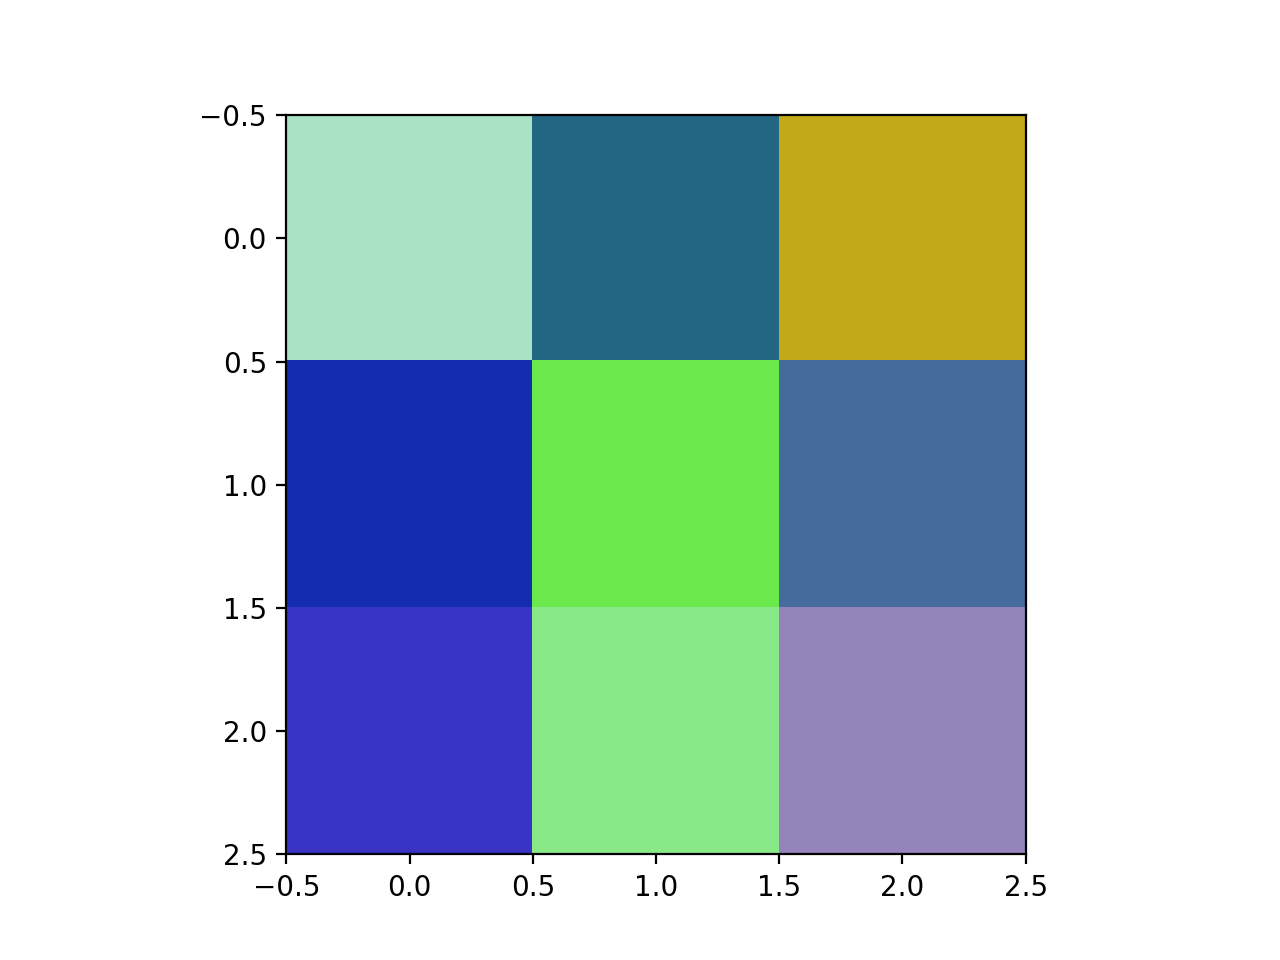

In [34]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
mm = vgg_model.double()
filters = mm.modules
body_model = [i for i in mm.children()][0]
layer1 = body_model[0]
tensor = layer1.weight.data.numpy()
plt.figure()
plt.imshow(tensor[0])


In [147]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model = model.float()
for data in testloader:
    images, labels = data
    images, labels = to_var(images),labels
    outputs = vgg_model(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted.cpu().numpy() == labels.numpy()).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane :  2 %
Accuracy of   car :  1 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer : 69 %
Accuracy of   dog : 25 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


In [236]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model = model.float()
for data in testloader:
    images, labels = data
    images, labels = to_var(images),labels
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted.cpu().numpy() == labels.numpy()).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship : 100 %
Accuracy of truck :  0 %


In [33]:
def to_var(x, requires_grad=False, volatile=False):
    """
    Varialbe type that automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

def prune_rate(model, verbose=True):
    """
    adapted from 
    """
    total_nb_param = 0
    nb_zero_param = 0

    layer_id = 0

    for parameter in model.parameters():

        param_this_layer = 1
        for dim in parameter.data.size():
            param_this_layer *= dim
        total_nb_param += param_this_layer

        # only pruning linear and conv layers
        if len(parameter.data.size()) != 1:
            layer_id += 1
            zero_param_this_layer = \
                np.count_nonzero(parameter.cpu().data.numpy()==0)
            nb_zero_param += zero_param_this_layer

            if verbose:
                print("Layer {} | {} layer | {:.2f}% parameters pruned" \
                    .format(
                        layer_id,
                        'Conv' if len(parameter.data.size()) == 4 \
                            else 'Linear',
                        100.*zero_param_this_layer/param_this_layer,
                        ))
    pruning_perc = 100.*nb_zero_param/total_nb_param
    if verbose:
        print("Final pruning rate: {:.2f}%".format(pruning_perc))
    return pruning_perc

In [ ]:
modules = list(self.model.modules())
        for i in range(1,len(modules)):
            model_sizes = []
            current_mod = modules[i]
            params = list(current_mod.parameters())
            for j in range(len(params)):
                parameters = params[j].data.cpu().numpy()
                non_zero = parameters[parameters>0]
                model_sizes.append(np.size(parameters))

        num_bits = 0
        bits = 32 #32 bit floats
        for i in range(len(model_sizes)):
            s = model_sizes[i]
            bits = np.prod(np.array(s))*bits
            num_bits += bits
        print(num_bits)
        return num_bits

In [11]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = to_var(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)
        
        
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = to_var(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        else:
            return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        

In [278]:
class PruneWrapSparse():# could also use this to maks out entire filters accoring to taylor criterion
    def __init__(self,train_start,model,sparsity_initial,sparsity_target,prune_steps,update_rate,train):
        #model params
        self.model = model.float()
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_loader = train
        self.optimizer = optim.SGD(self.model.classifier.parameters(), lr=0.0001, momentum=0.9)

        
        #bookkeeping
        self.current_sparsity=0
        self.sparsity_target = sparsity_target
        self.sparsity_initial = sparsity_initial
        self.train_step = train_start
        self.prune_steps =prune_steps
        self.update_rate = update_rate
        self.prunning = True
        self.running_loss = 0
        
    def to_string(self):
        print "current sparsity: " + str(self.current_sparsity)
        print "sparsity target: "+ str(self.sparsity_target)
        print "initial sparsity: " + str(self.sparsity_initial)
        print "current train step: "+ str(self.train_step)
        print "prune steps: "+str(self.prune_steps)
        print "prunning rate: "+str(self.update_rate)
        
    def test(self,test_data_loader):
        self.model.eval()
        
        correct, samples = 0, len(test_data_loader.dataset)
        for x, y in test_data_loader:
            x_var = to_var(x, volatile=True)
            scores = self.model(x_var)
            _, preds = scores.data.cpu().max(1)
            correct += (preds == y).sum()

        return float(correct)/samples
    
    def reset(self):
        self.current_sparsity=0.
        self.train_step = 0.
        self.current_sparsity = 0.
    
    def compute_current_target(self):
        return self.sparsity_target+(self.sparsity_initial-self.sparsity_target)*(1-(float(self.train_step)/(self.prune_steps*self.update_rate)))**3
    
    def train(self, optimizer = None, epoches = 10):
        start = time.time()
        for i in range(epoches):
            print self.to_string()
            print "epoch: ", i
            print self.current_sparsity
            for batch, label in self.train_loader:
                #stop prunning?
                if self.prunning and self.current_sparsity >= self.sparsity_target:
                    self.prunning = False
                    print "finished prunning"
                #should i prune?
                if self.prunning and self.train_step%self.update_rate==0:
                    print self.train_step
                    print self.running_loss/float(self.update_rate)
                    self.running_loss = 0
                    self.prune()
                    print prune_rate(self.model)
                #train
                batch,label = (to_var(batch),to_var(label))
                self.optimizer.zero_grad()
                loss = self.criterion(self.model(batch), label)
                loss.backward()
                self.optimizer.step()
                self.running_loss+=loss

                self.train_step+=1
            print prune_rate(self.model)
            print self.test(testloader)
        print "Finished fine tuning."
        print "Time elapsed:" + str((time.time() - start))

    def prune(self):#all conv layers for now
        current_sparsity_target = self.compute_current_target()
        print current_sparsity_target
        print self.to_string()
        for seq in list(self.model.children()):
            for layer in seq:
                if isinstance(layer, MaskedLinear):
                    #find weight threshold for layer
                    weight_threshold = self.get_weight_threshold(layer.parameters(),current_sparsity_target) 
                    #set mask
                    mask = self.get_prune_mask(layer,weight_threshold)
                    #prune
                    layer.set_mask(mask)
        self.current_sparsity = current_sparsity_target # more accurate actually figure out hw much was prunned
       
    def get_prune_mask(self,layer,threshold):
        # generate mask
        p=layer.weight.data.abs()
        pruned_inds = p > threshold
        return pruned_inds.float()
        
    def save_weight_hist(self,params):
        params = []
        plt.figure()
        for p in self.model.parameters():
            params.extend(list(p.data.cpu().abs().numpy().flatten()))
        plt.hist(params,bins=100,range=[0, 1])
        plt.show()
        
    def get_weight_threshold(self,params,percent_to_prune):
        weights=[]
        for param in params:
            if len(list(param.cpu().data.abs().numpy().flatten()))>1:
                weights.extend(list(param.cpu().data.abs().numpy().flatten()))
        threshold = np.percentile(np.array(weights),percent_to_prune*100)
        #print len(np.nonzero(np.array(weights)))/float(len(weights))
        return threshold
    
    def calculate_current_model_size(self):
        modules = list(self.model.modules())
        for i in range(1,len(modules)):
            model_sizes = []
            current_mod = modules[i]
            params = list(current_mod.parameters())
            for j in range(len(params)):
                parameters = params[j].data.cpu().numpy()
                non_zero = parameters[parameters>0]
                model_sizes.append(np.size(parameters))

        num_bits = 0
        bits = 32 #32 bit floats
        for i in range(len(model_sizes)):
            s = model_sizes[i]
            bits = np.prod(np.array(s))*bits
            num_bits += bits
        print(num_bits)
        return num_bits
    
    def calculate_current_model_size2(self):
        total_nb_param = 0
        nb_zero_param = 0
        for parameter in self.model.parameters():
            total_nb_param += np.size(parameter.cpu().data.abs().numpy())
            #if len(parameter.data.size()) != 1:
            zero_param_this_layer = np.count_nonzero(parameter.cpu().data.abs().numpy()>0)
            nb_zero_param += zero_param_this_layer

        bits = 32 #32 bit floats
        print bits*total_nb_param,bits*nb_zero_param
        return bits*total_nb_param
   
    
    def calculate_current_model_inference_time(self,samples=10):
        time_sum =0
        for i in range(samples):
            (batch, label) = next(iter(self.train_loader))
            input = Variable(batch.float())
            start = time.time()
            output = self.model(input)
            time_sum+=time.time() - start
        print "Time elapsed:" + str((time_sum/float(samples)))    
            

In [283]:
epoch_start,model,sparsity_initial,sparsity_target,prune_steps,update_rate,train,gpu=False):

SyntaxError: invalid syntax (<ipython-input-283-6e4a567f749a>, line 1)

In [87]:
138357544*32

4427441408

In [279]:
prune = PruneWrapSparse(1000,model,0,.2,100,500,trainloader)
prune.calculate_current_model_size()
prune.calculate_current_model_size2()

#prune.calculate_current_model_inference_time(10)

56320
315328 315328


315328

In [233]:
prune_rate(model)

Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Conv layer | 0.00% parameters pruned
Layer 10 | Conv layer | 0.00% parameters pruned
Layer 11 | Conv layer | 0.00% parameters pruned
Layer 12 | Conv layer | 0.00% parameters pruned
Layer 13 | Conv layer | 0.00% parameters pruned
Layer 14 | Linear layer | 0.00% parameters pruned
Layer 15 | Linear layer | 0.00% parameters pruned
Layer 16 | Linear layer | 0.00% parameters pruned
Final pruning rate: 0.00%


0.0

<IPython.core.display.Javascript object>


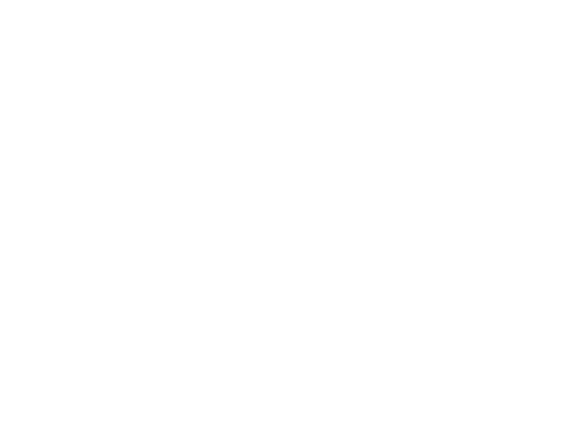

In [210]:
params = []
plt.figure()
for p in model.parameters():
    params.extend(list(p.data.cpu().abs().numpy().flatten()))
plt.hist(params,bins=100,range=[0, .1])
plt.show()
        

In [282]:
prune.test(testloader)

0.1791

In [281]:
prune.train()#nonzeros vs zeroing out in forward pass

current sparsity: 0
sparsity target: 0.2
initial sparsity: 0
current train step: 1000
prune steps: 100
prunning rate: 500
None
epoch:  0
0
1000
0.0
0.0117616
current sparsity: 0
sparsity target: 0.2
initial sparsity: 0
current train step: 1000
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 1.17% parameters pruned
Layer 10 | Linear layer | 1.17% parameters pruned
Layer 11 | Linear layer | 1.25% parameters pruned
Final pruning rate: 0.08%
0.0811853054597
1500
Variable containing:
 2.1961
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.0174654
current sparsity: 0.0117616
sparsity target: 0.2
initial spa

6500
Variable containing:
 2.1304
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.0682994
current sparsity: 0.0637056
sparsity target: 0.2
initial sparsity: 0
current train step: 6500
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 6.25% parameters pruned
Layer 10 | Linear layer | 5.86% parameters pruned
Layer 11 | Linear layer | 7.50% parameters pruned
Final pruning rate: 0.44%
0.436371016846
7000
Variable containing:
 2.1305
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.0727888
current sparsity: 0.0682994
sparsity target: 0.2
initial sparsity: 0
current train step: 7000
prune steps: 100
prunning rat

12000
Variable containing:
 2.0805
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1122048
current sparsity: 0.1086934
sparsity target: 0.2
initial sparsity: 0
current train step: 12000
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 10.16% parameters pruned
Layer 10 | Linear layer | 10.16% parameters pruned
Layer 11 | Linear layer | 11.25% parameters pruned
Final pruning rate: 0.71%
0.710371422772
12500
Variable containing:
 2.0933
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.115625
current sparsity: 0.1122048
sparsity target: 0.2
initial sparsity: 0
current train step: 12500
prune steps: 100
prunni

17000
Variable containing:
 2.0845
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1425008
current sparsity: 0.1398474
sparsity target: 0.2
initial sparsity: 0
current train step: 17000
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 12.50% parameters pruned
Layer 10 | Linear layer | 13.28% parameters pruned
Layer 11 | Linear layer | 15.00% parameters pruned
Final pruning rate: 0.91%
0.913334686422
17500
Variable containing:
 2.1019
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.145075
current sparsity: 0.1425008
sparsity target: 0.2
initial sparsity: 0
current train step: 17500
prune steps: 100
prunni

22500
Variable containing:
 2.0833
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.166725
current sparsity: 0.1648768
sparsity target: 0.2
initial sparsity: 0
current train step: 22500
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 15.23% parameters pruned
Layer 10 | Linear layer | 15.23% parameters pruned
Layer 11 | Linear layer | 17.50% parameters pruned
Final pruning rate: 1.08%
1.07570529734
23000
Variable containing:
 2.1009
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1685072
current sparsity: 0.166725
sparsity target: 0.2
initial sparsity: 0
current train step: 23000
prune steps: 100
prunning

27500
Variable containing:
 2.0804
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.181775
current sparsity: 0.1805328
sparsity target: 0.2
initial sparsity: 0
current train step: 27500
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 16.80% parameters pruned
Layer 10 | Linear layer | 16.41% parameters pruned
Layer 11 | Linear layer | 18.75% parameters pruned
Final pruning rate: 1.17%
1.16703876598
28000
Variable containing:
 2.1021
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1829632
current sparsity: 0.181775
sparsity target: 0.2
initial sparsity: 0
current train step: 28000
prune steps: 100
prunning

33000
Variable containing:
 2.1036
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1921392
current sparsity: 0.191425
sparsity target: 0.2
initial sparsity: 0
current train step: 33000
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 17.58% parameters pruned
Layer 10 | Linear layer | 17.58% parameters pruned
Layer 11 | Linear layer | 20.00% parameters pruned
Final pruning rate: 1.24%
1.23807590826
33500
Variable containing:
 2.0944
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1928126
current sparsity: 0.1921392
sparsity target: 0.2
initial sparsity: 0
current train step: 33500
prune steps: 100
prunnin

Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 17.97% parameters pruned
Layer 10 | Linear layer | 18.36% parameters pruned
Layer 11 | Linear layer | 20.62% parameters pruned
Final pruning rate: 1.28%
1.27866856099
0.181
current sparsity: 0.1972352
sparsity target: 0.2
initial sparsity: 0
current train step: 38500
prune steps: 100
prunning rate: 500
None
epoch:  3
0.1972352
38500
Variable containing:
 2.0861
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1975666
current sparsity: 0.1972352
sparsity target: 0.2
initial sparsity: 0
current train step: 38500
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters prune

43500
Variable containing:
 2.0917
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1995606
current sparsity: 0.1994512
sparsity target: 0.2
initial sparsity: 0
current train step: 43500
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 18.36% parameters pruned
Layer 10 | Linear layer | 19.14% parameters pruned
Layer 11 | Linear layer | 20.62% parameters pruned
Final pruning rate: 1.31%
1.30911305054
44000
Variable containing:
 2.0847
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1996544
current sparsity: 0.1995606
sparsity target: 0.2
initial sparsity: 0
current train step: 44000
prune steps: 100
prunni

49000
Variable containing:
 2.0701
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1999984
current sparsity: 0.1999946
sparsity target: 0.2
initial sparsity: 0
current train step: 49000
prune steps: 100
prunning rate: 500
None
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Linear layer | 18.75% parameters pruned
Layer 10 | Linear layer | 19.53% parameters pruned
Layer 11 | Linear layer | 20.62% parameters pruned
Final pruning rate: 1.33%
1.3294093769
49500
Variable containing:
 2.0900
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.1999998
current sparsity: 0.1999984
sparsity target: 0.2
initial sparsity: 0
current train step: 49500
prune steps: 100
prunnin

Process Process-261:
Process Process-262:
Traceback (most recent call last):
    racquire()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    return recv()
KeyboardInterrupt
  F

KeyboardInterrupt: 

In [184]:

# Hyper Parameters
param = {
    'pruning_perc': 90.,
    'batch_size': 128, 
    'test_batch_size': 100,
    'num_epochs': 5,
    'learning_rate': 0.001,
    'weight_decay': 5e-4,
}

# prune the weights
masks = weight_prune(vgg_model, param['pruning_perc'])
vgg_model.set_masks(masks)
print("--- {}% parameters pruned ---".format(param['pruning_perc']))
test(vgg_model, testloader)


# Retraining
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=param['learning_rate'], 
                                weight_decay=param['weight_decay'])

train(net, criterion, optimizer, param, loader_train)


# Check accuracy and nonzeros weights in each layer
print("--- After retraining ---")
test(net, loader_test)
prune_rate(net)


# Save and load the entire model
torch.save(net.state_dict(), 'vgg_pruned.pkl')

NameError: name 'weight_prune' is not defined

In [265]:
'''
Modified from https://github.com/pytorch/vision.git
'''
import math
import torch.nn as nn
import torch.nn.init as init

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]
#make vgg with masked layers
class VGG(nn.Module):
    def __init__(self, features,width=512,classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            MaskedLinear(width,width),
            nn.ReLU(True),
            nn.Dropout(),
            MaskedLinear(width, width),
            nn.ReLU(True),
            nn.Dropout(),
            MaskedLinear(width, classes),
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = MaskedConv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
    'T': [2, 'M', 4, 'M', 8, 8, 'M', 16, 16, 'M', 16, 16, 'M'],
}
def vgg_lite():
    return VGG(make_layers(cfg['T']),width=16)

def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))

def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

### adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

notes:

questions?:
    1. Data involved or data agnostic
    2. during training or after
    3. Inference citeria, or backprop criteria.
    4. at what point during training do you prune
    5. using gradient and activation signals if one is high
    6. train from scratch work or need long burn in time
    7. VGG is notoriously slow to train with large memory footprint, what about squeeznet, arcitectures that are just better
    8. layerwise or globally
    9. when using speed as metric have to make sure your prunning method is super efficient
 Channel-wise
 10. if not layerwise how do params get masked over time, in what layersc
SSL [49] reaches high compression ratio for first few conv
layers of LeNet [30] and AlexNet [26]. [54] could work
well for fully connected layers. However, training-based
approaches are more costly, and the effectiveness for very
deep networks on large datasets is rarely exploited

